# Skin Segmentation

The skin dataset is collected by randomly sampling B,G,R values from face images of various age groups (young, middle, and old), race groups (white, black, and asian), and genders obtained from FERET database and PAL database. Total learning sample size is 245057; out of which 50859 is the skin samples and 194198 is non-skin samples.

### Environment Check

In [11]:
from __future__ import division
import sys
print sys.version

2.7.9 |Anaconda 2.2.0 (64-bit)| (default, Mar  9 2015, 16:20:48) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [30]:
import IPython
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for module in [IPython, sklearn, pd, sns]:
    print module.__name__, ':', module.__version__

IPython : 3.0.0
sklearn : 0.16.0
pandas : 0.16.0
seaborn : 0.5.1


### Data Acquisition

In [13]:
DATA_URL = "http://archive.ics.uci.edu/ml/machine-learning-databases/00229/Skin_NonSkin.txt"
DATA_DIR = '../../data/'

In [14]:
#!curl {DATA_URL} > {DATA_DIR}skin.tsv

In [15]:
!head {DATA_DIR}skin.tsv

### Data Hygiene

In [16]:
features = ['B','G','R','skin']
df = pd.read_csv(DATA_DIR + 'skin.tsv',
                    delimiter='\t',
                    names=features)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245057 entries, 0 to 245056
Data columns (total 4 columns):
B       245057 non-null int64
G       245057 non-null int64
R       245057 non-null int64
skin    245057 non-null int64
dtypes: int64(4)
memory usage: 9.3 MB


In [18]:
# any of the columns have missing values?
any([pd.isnull(col) for col in df])

False

In [19]:
# inspect a random sample of rows
from random import sample
df.ix[sample(df.index,10)]

,B,G,R,skin
191625,179,176,132,2
31140,153,167,220,1
108893,180,180,186,2
147443,178,178,132,2
51358,171,170,119,2
175360,185,180,141,2
173872,199,195,160,2
102162,15,28,12,2
95162,71,73,27,2
96738,195,121,65,2


In [20]:
# iiieeuuww! The skin is encoded as '1' and non-skin as '2'. Let's standardise to 0 for non-skin and 1 for skin.
df.ix[df.skin == 2,'skin'] = 0

In [21]:
# re-inspect a random sample of rows
from random import sample
df.ix[sample(df.index,10)]

,B,G,R,skin
177391,136,134,94,0
45321,122,163,226,1
241789,163,162,112,0
183523,138,139,89,0
43284,117,154,222,1
97401,73,74,32,0
232020,21,11,4,0
85409,37,35,34,0
97294,198,124,68,0
10807,125,164,216,1


### Exploratory Data Analysis

In [22]:
sns.set(style="white", palette="muted")

In [23]:
# numerically
vc = df.skin.value_counts()
print "skin (total) : %d" % (vc[1])
print "non-skin (total) : %d" % (vc[0])
print "skin (percent) : %.2f" % (vc[1]/df.skin.count())
print "non-skin (percent) : %.2f" % (vc[0]/df.skin.count())


skin (total) : 50859
non-skin (total) : 194198
skin (percent) : 0.21
non-skin (percent) : 0.79


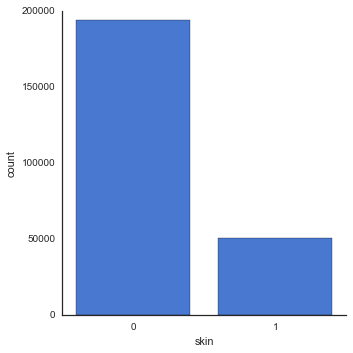

In [24]:
# visually
sns.factorplot("skin", data=df);

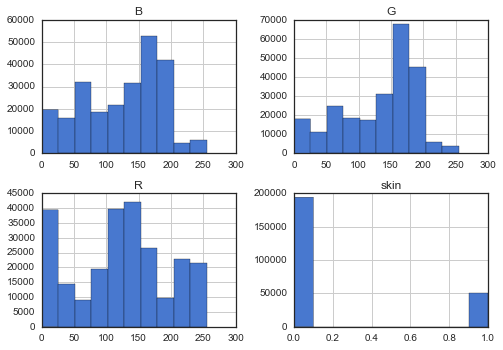

In [25]:
df.hist();

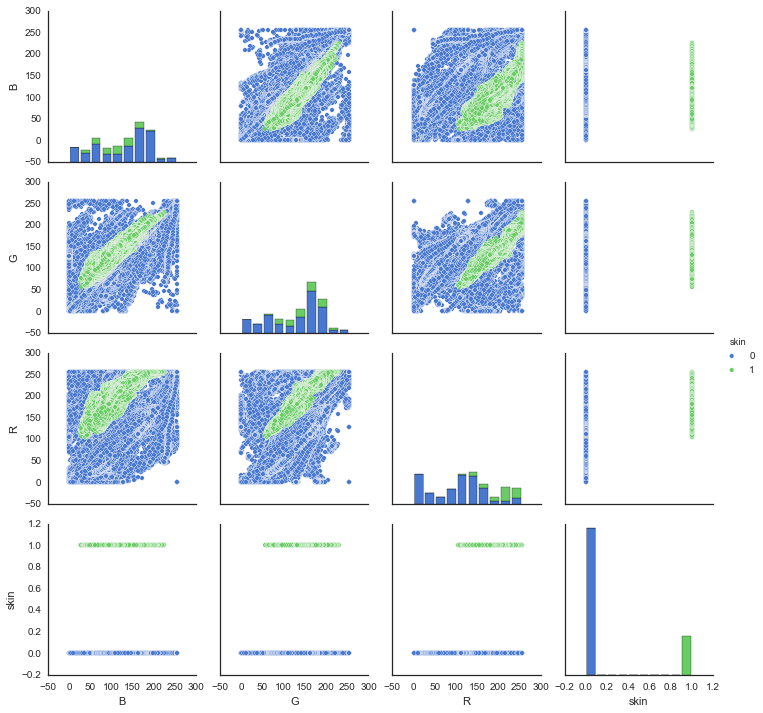

In [26]:
sns.pairplot(df, hue="skin", size=2.5);

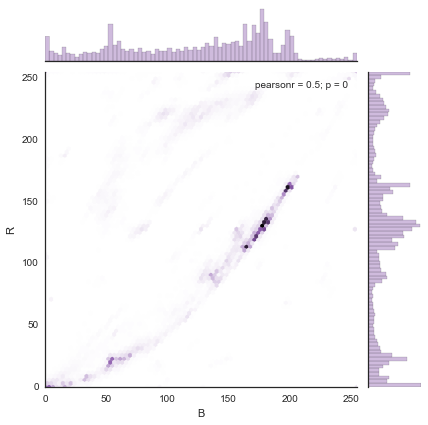

In [27]:
sns.jointplot("B", "R", df, kind="hex", color="#8855AA");

### Cross-validated KNN

* We need to create classes of equal size.
* The data does not need to be rescaled as the are all on the same scale.

#### Balancing classes

In [32]:
import random
feat = 'skin'
n = min(df[feat].value_counts())
max_class = int(df[feat].value_counts().idxmax())
max_rows = random.sample(df[df[feat] == max_class].index, n)
min_class = int(df[feat].value_counts().idxmin())
min_rows = df[df[feat] == min_class].index
rows = np.r_[min_rows, max_rows]

In [34]:
dfx = df.ix[rows,:]

In [35]:
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier as KNN

In [36]:
k_neighbors = 10
clf = KNN(k_neighbors)

X = dfx.ix[:,:-1]
y = dfx.ix[:,-1]

scores = cross_validation.cross_val_score(clf, X, y, cv=5)

In [37]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.993 (+/- 0.022)


### Getting Predictions out of your Cross-validated Model

In [38]:
from sklearn.metrics import classification_report

In [39]:
predicted = cross_validation.cross_val_predict(clf, X, y, cv=10)

print classification_report(y, predicted)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     50859
          1       1.00      0.99      0.99     50859

avg / total       0.99      0.99      0.99    101718

